In [25]:
import re
import nltk, numpy, string
import pandas as pd
import networkx as nx
from pyvis.network import Network
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

In [26]:
positive_graphml = nx.read_graphml('positive.graphml')
negative_graphml = nx.read_graphml('negative.graphml')

positive_graph = nx.Graph(positive_graphml)
negative_graph = nx.Graph(negative_graphml)

In [27]:
def preprocess(text):
    html_tag = r"<[^>]+>"
    url = r"(http|https)://[^\s]*"

    tokens = nltk.word_tokenize(text)
    tokens = [token.lower() for token in tokens]
    tokens = [token for token in tokens if token not in string.punctuation]
    tokens = [token for token in tokens if not bool(re.search(html_tag, token))]
    tokens = [token for token in tokens if not bool(re.search(url, token))]

    stopwords = nltk.corpus.stopwords.words('english')
    stopwords_removed = [token for token in tokens if token not in stopwords]

    lemmatizer = nltk.stem.WordNetLemmatizer()
    lemmas = [lemmatizer.lemmatize(token) for token in stopwords_removed]

    stemmer = nltk.stem.PorterStemmer()
    stems = [stemmer.stem(token) for token in stopwords_removed]

    return lemmas, stems


In [28]:
def create_word_graph(tokens, word_frame):
    graph = nx.Graph()
    graph.add_nodes_from(tokens)

    for i in range(len(tokens) - 1):
        for j in range(word_frame - 1):
            if i + j + 1 < len(tokens):
                graph.add_edge(tokens[i], tokens[i + j + 1])


    return graph

In [29]:
def get_eigenvector_centrality_vote(positive_graph, negative_graph, text_graph):
    positive_eingenvector = nx.eigenvector_centrality(positive_graph)
    negative_eingenvector = nx.eigenvector_centrality(negative_graph)

    positive_score = 0
    negative_score = 0

    for node in text_graph:
        positive_score += positive_eingenvector[node]
        negative_score += negative_eingenvector[node]

    if positive_score > negative_score:
        return 1
    elif positive_score < negative_score:
        return -1
    else:
        return 0

In [30]:
def get_pagerank_vote(positive_graph, negative_graph, text_graph):
    positive_pagerank = nx.pagerank(positive_graph)
    negative_pagerank = nx.pagerank(negative_graph)

    positive_score = 0
    negative_score = 0

    for node in text_graph:
        positive_score += positive_pagerank[node]
        negative_score += negative_pagerank[node]

    if positive_score > negative_score:
        return 1
    elif positive_score < negative_score:
        return -1
    else:
        return 0

In [31]:
def senti_election(positive_graph, negative_graph, tokens):
    text_graph = create_word_graph(tokens, 3)

    positive_graph_composed = nx.compose(positive_graph, text_graph)
    negative_graph_composed = nx.compose(negative_graph, text_graph)

    final_score = 0
    final_score += get_eigenvector_centrality_vote(positive_graph_composed, negative_graph_composed, text_graph)
    # final_score += get_pagerank_vote(positive_graph_composed, negative_graph_composed, text_graph)

    return final_score


In [33]:
data = pd.read_csv('movie.csv', skiprows=1000, nrows=100)

data.columns = ['text', 'label']

positives = data[data['label'] == 1].values
negatives = data[data['label'] == 0].values

print('Positive')
cont_pos = 0
for text in positives:
    lemmas, stems = preprocess(text[0])
    res = senti_election(positive_graph, negative_graph, stems)
    print(res)
    if res == 1:
        cont_pos += 1

cont_neg = 0
print('Negative')
for text in negatives:
    lemmas, stems = preprocess(text[0])
    res = senti_election(positive_graph, negative_graph, stems)
    print(res)
    if res == -1:
        cont_neg += 1

print(f'Positive: {cont_pos}/{len(positives)}')
print(f'Negative: {cont_neg}/{len(negatives)}')

Positive
1
1
1
1
1
1
1
-1
-1
1
1
1
-1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
-1
-1
1
1
-1
1
-1
1
1
1
1
1
1
1
1
-1
1
-1
1
1
1
1
Negative
1
-1
-1
-1
-1
-1
1
-1
-1
1
-1
-1
-1
-1
1
-1
-1
-1
-1
-1
1
1
-1
-1
-1
-1
1
-1
-1
-1
-1
1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
Positive: 39/49
Negative: 43/51


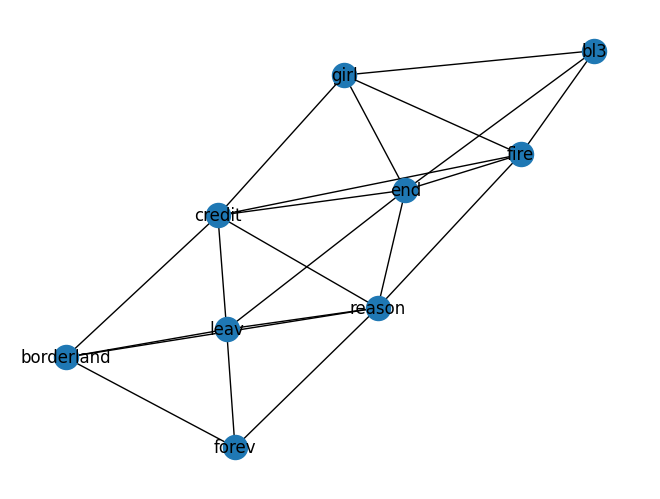

In [24]:
text = "bl3 with girl on fire for the end credits is the reason why I will leave Borderlands forever"
lemmas, stems = preprocess(text)
test_graph = create_word_graph(stems, 4)

nx.draw(test_graph, with_labels=True)